In [50]:
import pandas as pd

In [51]:
df = pd.read_csv("car_fuel_efficiency.csv")

In [52]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [53]:
df=df[[
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]]


In [54]:
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


In [55]:
df.model_year.nunique()

24

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

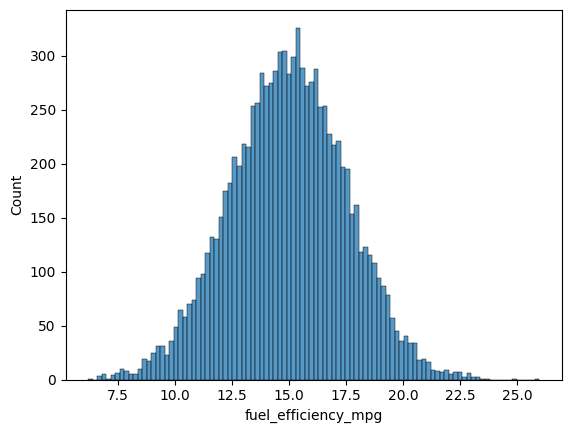

In [57]:
sns.histplot(df.fuel_efficiency_mpg, bins=100)


In [58]:
df.horsepower.median()

np.float64(149.0)

In [59]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [60]:
# from sklearn.model_selection import train_test_split ???

n = len(df)
n_test = int(.2*n)
n_val = int(.2*n)
n_train = n - n_test - n_val
n

9704

In [61]:
import numpy as np
print( np.sum([n_test, n_val, n_train]))
n_test, n_val, n_train

9704


(1940, 1940, 5824)

In [62]:
np.random.seed(42)
np.random.shuffle(idx:=np.arange(n))
    
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

#could have used train_test_split

In [63]:
df_train.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822
1688,150,206.0,3748.164469,2015,11.818843
6217,300,111.0,2135.716359,2006,19.402209


In [64]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [65]:
y_train = df_train.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values

In [66]:
del df_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']

df_train.head()

,engine_displacement,horsepower,vehicle_weight,model_year
0,220,144.0,2535.887591,2009
1,160,141.0,2741.170484,2019
2,230,155.0,2471.880237,2017
3,150,206.0,3748.164469,2015
4,300,111.0,2135.716359,2006


# REGRESSION

In [67]:
fillwith = lambda val, *args: [ a.fillna({"horsepower": val}) for a in args]

## Using mean

In [68]:
mean = df_train.horsepower.mean()
df_train_mean, df_test_mean, df_val_mean = fillwith(mean, df_train, df_test, df_val)

In [69]:
X = np.hstack((np.ones((df_train.shape[0],1)), df_train_mean.values))
X_val = np.hstack((np.ones((df_val_mean.shape[0],1)), df_val_mean.values))

In [70]:
w = np.linalg.inv(X.T@X)@X.T@y_train
rmse = ((X_val@w - y_val)**2).mean()**.5
rmse

np.float64(0.46359650423345844)

## Using zeroes

In [71]:
# this is strange we are doing that since it will shift all my distributions and give worse results than mean

df_train_zeros, df_test_zeros, df_val_zeros = fillwith(0, df_train, df_test, df_val)

X = np.hstack((np.ones((df_train_zeros.shape[0],1)), df_train_zeros.values))
X_val = np.hstack((np.ones((df_val_zeros.shape[0],1)), df_val_zeros.values))

w = np.linalg.inv(X.T@X)@X.T@y_train
rmse = ((X_val@w - y_val)**2).mean()**.5
rmse

np.float64(0.5173782638844465)

<Axes: ylabel='Count'>

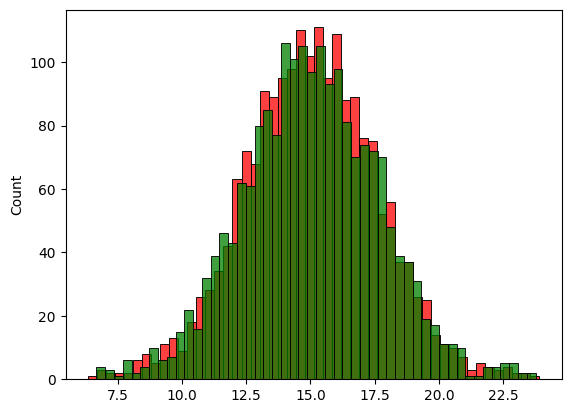

In [72]:
sns.histplot(X_val@w, color='red', bins=50)
sns.histplot(y_val, color='green', bins=50)

In [73]:
# Ridge normalization (adding small values to the eigenvalues of X.T@X to make sure vector X.T@y does not explode)
R = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_damped = [((X_val @ np.linalg.inv(X.T@X + r*np.identity(X.shape[1]))@X.T@y_train - y_val)**2).mean()**.5 for r in R]

In [74]:
rmse_damped

[np.float64(0.5173782638894002),
 np.float64(0.5171115525760246),
 np.float64(0.5187525130714695),
 np.float64(0.5222348802093596),
 np.float64(0.522891609282388),
 np.float64(0.5229812979636335),
 np.float64(0.5230636233819945)]

In [75]:
eigvals = np.linalg.eigvalsh(X.T @ X)
print(eigvals)


[6.39063152e-02 1.34440399e+07 1.42553528e+07 4.45675062e+08
 7.75543128e+10]


So we know that Hessian of Linear regression is 2X.TX and in the LR formula we take an inverse of half of this (X.TX)-1. we know that hessian is symmetric cuz df/dx1d2 = df/dx2dx1 which allows us to perform SVD on it. So whatever vector is X.T*y it is being essentially linearly transformed by inverse hessian so most prominent transformation directions are along eigenvectors with smallest eigenvalues (since H is inverse). So we bump those values a little bit to decrease contributions.

RMSE for different values of r almost doesnt change because my hessian eigenvalues either tiny or huge. so i should choose either small r which makes almost no diff for huge eigenvalues or huge r which will regularize my small ones like hell. Those are regularized rmse values with different r:
```
[np.float64(0.5165003926235892),
 np.float64(0.5165892658555999),
 np.float64(0.5194055692705319),
 np.float64(0.5236285280576382),
 np.float64(0.5243861811918874),
 np.float64(0.5244890955846669),
 np.float64(0.5245834136669432)]
 ```
here's the hessian xtx eigenvalues
```
eigvals = np.linalg.eigvalsh(X.T @ X)
print(eigvals)
[6.39063152e-02 1.34440399e+07 1.42553528e+07 4.45675062e+08
 7.75543128e+10]
 ```
See the diif? Either it should mentioned we should normalize the data or ridge is pointless. Gonna redo below with feature normalization.

In [76]:
max_year = df_train_zeros.model_year.max()

def add_age(df):
    df = df.copy()
    df["age"] = max_year - df.model_year
    del df['model_year']
    return df

df_train_zeros_normalized = add_age(df_train_zeros)
df_train_zeros_normalized_mean = df_train_zeros_normalized.mean()
df_train_zeros_normalized_std = df_train_zeros_normalized.std()
df_train_zeros_normalized = (df_train_zeros_normalized - df_train_zeros_normalized_mean )/df_train_zeros_normalized_std

df_val_zeros_normalized = add_age(df_val_zeros)
df_val_zeros_normalized = (df_val_zeros_normalized - df_train_zeros_normalized_mean)/df_train_zeros_normalized_std

df_test_zeros_normalized = add_age(df_test_zeros)
df_test_zeros_normalized = (df_test_zeros_normalized - df_train_zeros_normalized_mean)/df_train_zeros_normalized_std

X_train_norm = np.hstack((np.ones((df_train_zeros_normalized.shape[0],1)), df_train_zeros_normalized.values))
X_val_norm = np.hstack((np.ones((df_val_zeros_normalized.shape[0],1)), df_val_zeros_normalized.values))
X_test_norm = np.hstack((np.ones((df_test_zeros_normalized.shape[0],1)), df_test_zeros_normalized.values))

w_norm = np.linalg.inv(X_train_norm.T@X_train_norm)@X_train_norm.T@y_train

rmse_wo_ridge = ((X_val_norm@w_norm - y_val)**2).mean()**.5
print(f"RMSE w/o ridge: {rmse_wo_ridge}")

R = [0, 0.01, 0.1, 1, 5, 10, 100]
rmse_damped = [((X_val_norm @ (np.linalg.inv(X_train_norm.T@X_train_norm + r*np.identity(X_train_norm.shape[1]))@X_train_norm.T@y_train) - y_val)**2).mean()**.5 for r in R]
rmse_damped




RMSE w/o ridge: 0.517378263884094


[np.float64(0.517378263884094),
 np.float64(0.5173782024644953),
 np.float64(0.5173777093628829),
 np.float64(0.5173786841506897),
 np.float64(0.5175126911169711),
 np.float64(0.5179766453365773),
 np.float64(0.5773682238334296)]

OK now we see actual effect happens between values 10 and 100. Lowest rmse is 0, meaning the data is well distributed and no regularization needed since it fits val data well enough

# Question 5

In [77]:
seeds = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
rmses = []
for seed in seeds:
    np.random.seed(seed)
    np.random.shuffle(idx:=np.arange(n))
        
    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    
    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    df_train,df_val = fillwith(0., df_train, df_val)
    
    X = np.hstack((np.ones((df_train.shape[0],1)), df_train.values))
    X_val = np.hstack((np.ones((df_val.shape[0],1)), df_val.values))
    
    w = np.linalg.inv(X.T@X)@X.T@y_train
    rmse = ((X_val@w - y_val)**2).mean()**.5
    rmses.append(rmse)
np.array(rmses).std()

np.float64(0.006989446426433686)

# Question 6

In [78]:
np.random.seed(9)
np.random.shuffle(idx:=np.arange(n))
    
df_train = pd.concat([df.iloc[idx[:n_train]].reset_index(drop=True),
                     df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)])
y_train = df_train.fuel_efficiency_mpg.values

df_test = df.iloc[idx[n_train+n_val:]]
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_train,df_test = fillwith(0., df_train, df_test)

X = np.hstack((np.ones((df_train.shape[0],1)), df_train.values))
X_test = np.hstack((np.ones((df_test.shape[0],1)), df_test.values))

w = np.linalg.inv(X.T@X + 0.001*np.identity(X.shape[1]))@X.T@y_train
rmse = ((X_test@w - y_test)**2).mean()**.5
rmse

np.float64(0.5156261299169602)